In [23]:
# import the libraries
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, BatchNormalization, Dropout

import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
!7z x /content/drive/MyDrive/Claheclasses_1.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/                                 1 file, 268015777 bytes (256 MiB)

Extracting archive: /content/drive/MyDrive/Claheclasses_1.zip
 39% 4096 Open              --
Path = /content/drive/MyDrive/Claheclasses_1.zip
Type = zip
Physical Size = 268015777

  0%      4% 452 - Claheclasses_1/1/82_left.jpeg                                          7% 822 - Claheclasses_1/1/22520_left.jpeg                                            10% 1089 - Claheclasses_1/1/3074_left.jpeg

In [25]:
import pathlib
data_dir = '/content/Claheclasses_1'
data_dir = pathlib.Path(data_dir)

In [26]:
image_count = len(list(data_dir.glob('*/*.jpeg')))
print(image_count)

10304


In [27]:
batch_size = 32
img_height = 224
img_width = 224

In [28]:
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    shuffle = True,
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 10304 files belonging to 2 classes.


In [29]:
class_names = dataset.class_names
print(class_names)

['0', '1']


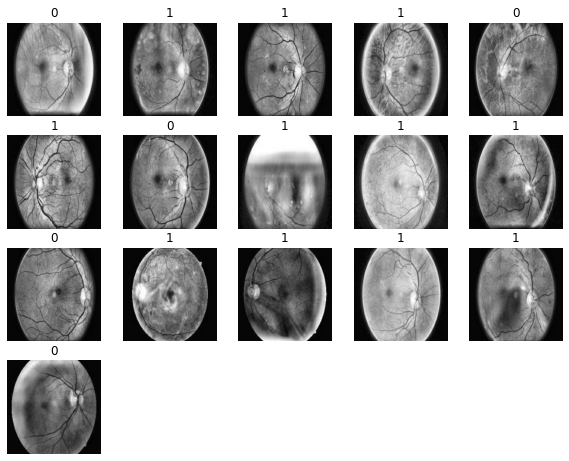

In [30]:
plt.figure(figsize=(10, 10))
for images_batch, labels_batch in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [31]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10304 files belonging to 2 classes.
Using 7213 files for training.


In [32]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10304 files belonging to 2 classes.
Using 3091 files for validation.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.5, seed=None),
    layers.RandomCrop(150, 150, seed=None)
  ]
)

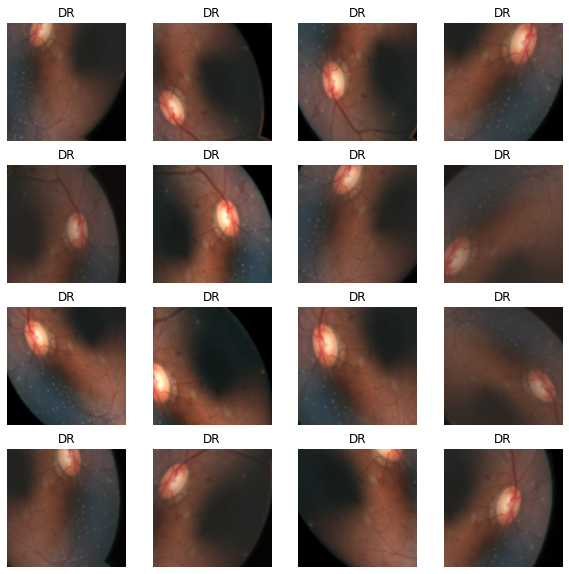

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(16):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0]])
        plt.axis("off")

In [33]:
num_classes = len(class_names)

# Transfer Learning

In [34]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model

In [35]:
base_vgg = model = VGG19(weights='imagenet', include_top=False)
base_vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [36]:
base_vgg.trainable = False

In [37]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_vgg(image_batch)
print(feature_batch.shape)

(32, 7, 7, 512)


In [38]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [39]:
prediction_layer = tf.keras.layers.Dense(8, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 8)


In [40]:
inputs = keras.Input(shape=(img_height, img_width, 3))
x = base_vgg(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.05)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [41]:
import time
start_cnn = time.time()

In [42]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [43]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

path = 'best_model_TLVGG19.hdf5'
checkpoint = ModelCheckpoint(path, monitor='val_accuracy', verbose = 1, save_best_only = True, mode='max')
es = EarlyStopping(monitor='val_accuracy', patience=5)

callback_list = [checkpoint,es]

In [44]:
epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callback_list  
)

Epoch 1/100
226/226 [==============================] - ETA: 0s - loss: 1.5012 - accuracy: 0.5081
Epoch 1: val_accuracy improved from -inf to 0.55904, saving model to best_model_TLVGG19.hdf5
226/226 [==============================] - 63s 277ms/step - loss: 1.5012 - accuracy: 0.5081 - val_loss: 0.8917 - val_accuracy: 0.5590
Epoch 2/100
226/226 [==============================] - ETA: 0s - loss: 0.8984 - accuracy: 0.5674
Epoch 2: val_accuracy improved from 0.55904 to 0.57878, saving model to best_model_TLVGG19.hdf5
226/226 [==============================] - 59s 262ms/step - loss: 0.8984 - accuracy: 0.5674 - val_loss: 0.7700 - val_accuracy: 0.5788
Epoch 3/100
226/226 [==============================] - ETA: 0s - loss: 0.7927 - accuracy: 0.5733
Epoch 3: val_accuracy improved from 0.57878 to 0.58460, saving model to best_model_TLVGG19.hdf5
226/226 [==============================] - 59s 261ms/step - loss: 0.7927 - accuracy: 0.5733 - val_loss: 0.7192 - val_accuracy: 0.5846
Epoch 4/100
226/226 [=

In [ ]:
print("Total time: ", time.time() - start_cnn, "seconds")

Total time:  2701.5167739391327 seconds


In [45]:
scores = model.evaluate(train_ds)

226/226 [==============================] - 42s 184ms/step - loss: 0.6206 - accuracy: 0.6502


In [46]:
scores = model.evaluate(val_ds)

97/97 [==============================] - 18s 183ms/step - loss: 0.6766 - accuracy: 0.6069


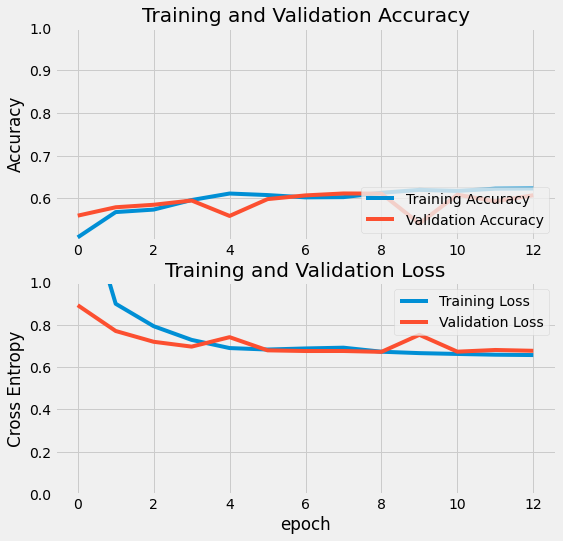

In [55]:
plt.style.use('fivethirtyeight')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Actual label: DR
1/1 [==============================] - 0s 176ms/step
[2.9885992e-01 7.0114005e-01 8.2486285e-17 5.1838934e-20 1.5046176e-18
 2.3866020e-23 4.0387638e-11 2.9799841e-20]
predicted label: DR


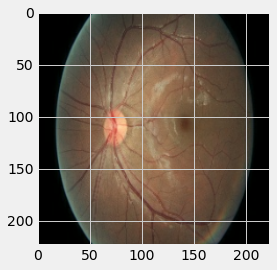

In [ ]:
import numpy as np
for images_batch, labels_batch in val_ds.take(1):
    
    first_image = images_batch[5].numpy().astype('uint8')
    first_label = labels_batch[5].numpy()

    plt.imshow(first_image)
    print("Actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print(batch_prediction[5])
    print("predicted label:",class_names[np.argmax(batch_prediction[5])])

In [53]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 17ms/step


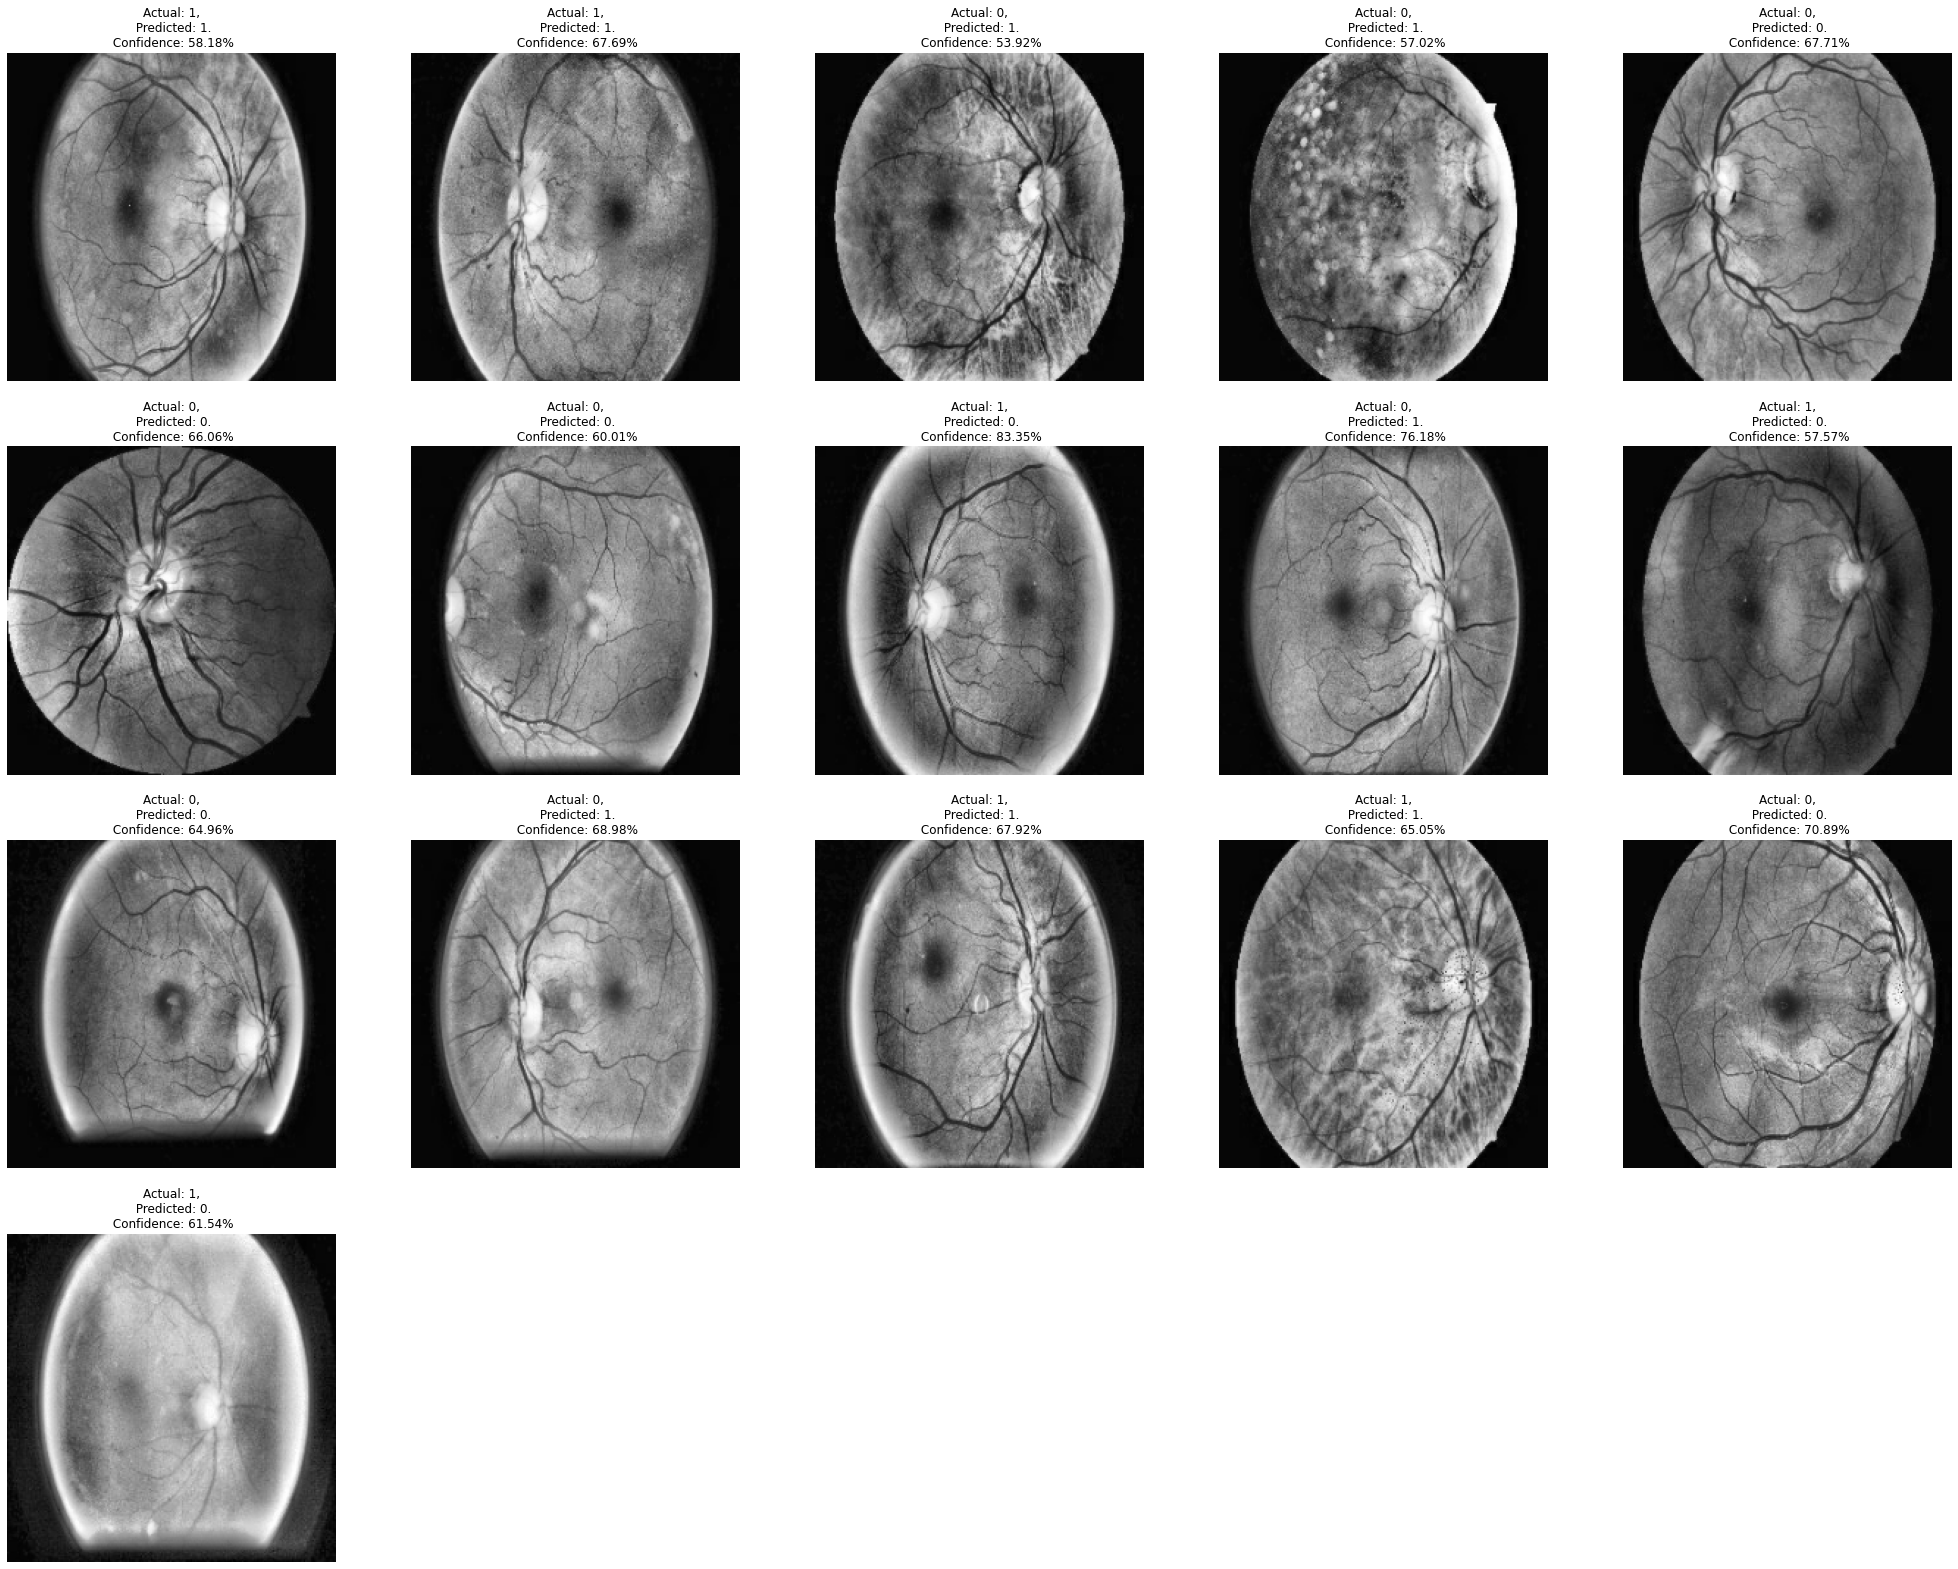

In [54]:
plt.figure(figsize=(35, 35))
for images, labels in val_ds.take(1):
    for i in range(16):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [47]:
X = []
y = []
for image,labels in val_ds.take(96):
    for i in image:
        img = i.numpy()
        X.append(img)
    lbl_list = labels.numpy()    
    y.extend(lbl_list)   

In [48]:
x = np.array(X)

In [49]:
y = np.array(y)

In [50]:
x.shape, y.shape

((3072, 224, 224, 3), (3072,))

In [ ]:
model.evaluate(x[:3059],y[:3059])

96/96 [==============================] - 17s 180ms/step - loss: 0.6652 - accuracy: 0.6139


[0.6651615500450134, 0.613926112651825]

In [51]:
from sklearn.metrics import confusion_matrix , classification_report
import numpy as np
y_pred = model.predict(x[:3072])
y_pred_classes = [np.argmax(element) for element in y_pred]
 
print("Classification Report: \n", classification_report(y[:3072], y_pred_classes))

96/96 [==============================] - 17s 174ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.59      0.74      0.66      1557
           1       0.64      0.47      0.54      1515

    accuracy                           0.61      3072
   macro avg       0.61      0.61      0.60      3072
weighted avg       0.61      0.61      0.60      3072



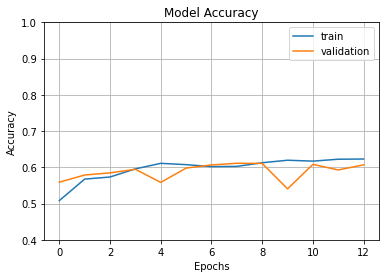

In [52]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()